Author: Lynn Menchaca

Date: 06Jan2024

Project: Airline Passengers Time Series

Resources:

- Youtube: Krish Naik - Time Series Live Lectures
    - https://www.youtube.com/playlist?list=PLZoTAELRMXVNty3jyJkYXuyQY3lMSpr3b


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# p, d, q values
import statsmodels.api as sms
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# models
#from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_path = '/Users/lynnpowell/Documents/DS_Projects/Time_Series_Tutorials/'

df_airline = pd.read_csv('airline_passengers.csv')
df_airline.head()

,Month,Thousands of Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [3]:
#checking null values
df_airline.isnull().sum()

Month                      0
Thousands of Passengers    1
dtype: int64

In [4]:
# Looking at the row with the null value in the "Thousands of Passengers" column

df_airline[df_airline['Thousands of Passengers'].isna()]

,Month,Thousands of Passengers
144,International airline passengers: monthly tota...,NaN


In [5]:
# The row with missing values is not one we need so droping

df_airline.dropna(axis=0,inplace=True)

In [6]:
# verifing no null values

df_airline.isnull().sum()

Month                      0
Thousands of Passengers    0
dtype: int64

In [7]:
df_airline.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    144 non-null    object 
 1   Thousands of Passengers  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.4+ KB


In [8]:
# "Month" column needs to be a date time type
df_airline['Month'] = pd.to_datetime(df_airline['Month'])

#Verifing the change
df_airline.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Month                    144 non-null    datetime64[ns]
 1   Thousands of Passengers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.4 KB


In [9]:
df_airline.head()

,Month,Thousands of Passengers
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


In [10]:
# Setting the month column as index

df_airline.set_index('Month',inplace=True)

df_airline.head()

,Thousands of Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


<AxesSubplot:xlabel='Month'>

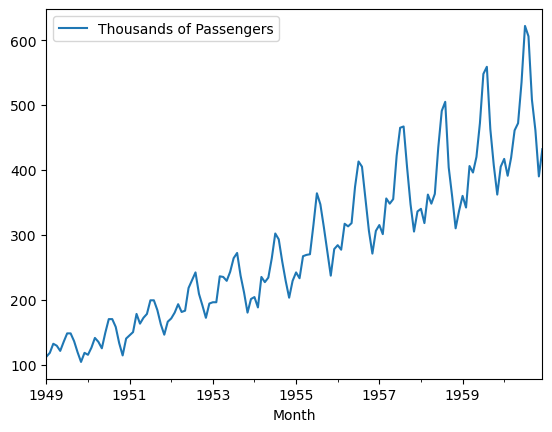

In [11]:
# Plotting the number of passengers vs time

df_airline.plot()


This plot is an example of seasonal data. Since the mean is increasing this means this data set is not Stationary.


In [12]:
# Function to perform Dickey Fuller Test on data
# verifing the data is not Stationary

def adf_test(series):
    #adfuller -> import from stats models
    result = adfuller(series)
    print(result)
    print('\n')
    print('ADF Statistics: ', result[0])
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary')
    else:
        print('Weak evidence against null hypothesis. Time series has a unit root, indicating it is non-stationary')
    

In [13]:
adf_test(df_airline['Thousands of Passengers'])

(0.8153688792060544, 0.9918802434376411, 13, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 996.692930839019)


ADF Statistics:  0.8153688792060544
p- value: 0.9918802434376411
Weak evidence against null hypothesis. Time series has a unit root, indicating it is non-stationary


In [14]:
# Converting the data set in to a Stationary data set
# Technique: Differencing
# .shift -> moves the column down one index
# Differencing is: index[1] - index[0]

df_airline['Passengers First Difference'] = df_airline['Thousands of Passengers'] - df_airline['Thousands of Passengers'].shift(1)

In [15]:
print('Head of Data Set')
print(df_airline.head())
print('\n')
print('Tail of Data Set')
print(df_airline.tail())

Head of Data Set
            Thousands of Passengers  Passengers First Difference
Month                                                           
1949-01-01                    112.0                          NaN
1949-02-01                    118.0                          6.0
1949-03-01                    132.0                         14.0
1949-04-01                    129.0                         -3.0
1949-05-01                    121.0                         -8.0


Tail of Data Set
            Thousands of Passengers  Passengers First Difference
Month                                                           
1960-08-01                    606.0                        -16.0
1960-09-01                    508.0                        -98.0
1960-10-01                    461.0                        -47.0
1960-11-01                    390.0                        -71.0
1960-12-01                    432.0                         42.0


<AxesSubplot:xlabel='Month'>

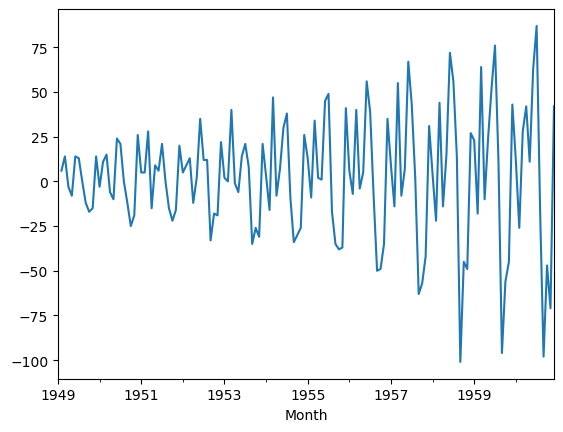

In [16]:
df_airline['Passengers First Difference'].plot()

In [17]:
# Performing the Dickey Fuller test to see if the differencing has made the data set stationary
#droping the first row since it has a null value

adf_test(df_airline['Passengers First Difference'].dropna())

(-2.8292668241700034, 0.054213290283824954, 12, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 988.5069317854084)


ADF Statistics:  -2.8292668241700034
p- value: 0.054213290283824954
Weak evidence against null hypothesis. Time series has a unit root, indicating it is non-stationary



The passengers first difference data set is still Not Stationary. This means we need to perform differencing again, this time on the passengers first difference data set.


In [18]:
# 2nd pass using Differencing Technique

df_airline['Passengers Second Difference'] = df_airline['Passengers First Difference'] - df_airline['Passengers First Difference'].shift(1)

In [19]:
print('Head of Data Set')
print(df_airline.head())
print('\n')
print('Tail of Data Set')
print(df_airline.tail())

Head of Data Set
            Thousands of Passengers  Passengers First Difference  \
Month                                                              
1949-01-01                    112.0                          NaN   
1949-02-01                    118.0                          6.0   
1949-03-01                    132.0                         14.0   
1949-04-01                    129.0                         -3.0   
1949-05-01                    121.0                         -8.0   

            Passengers Second Difference  
Month                                     
1949-01-01                           NaN  
1949-02-01                           NaN  
1949-03-01                           8.0  
1949-04-01                         -17.0  
1949-05-01                          -5.0  


Tail of Data Set
            Thousands of Passengers  Passengers First Difference  \
Month                                                              
1960-08-01                    606.0               

<AxesSubplot:xlabel='Month'>

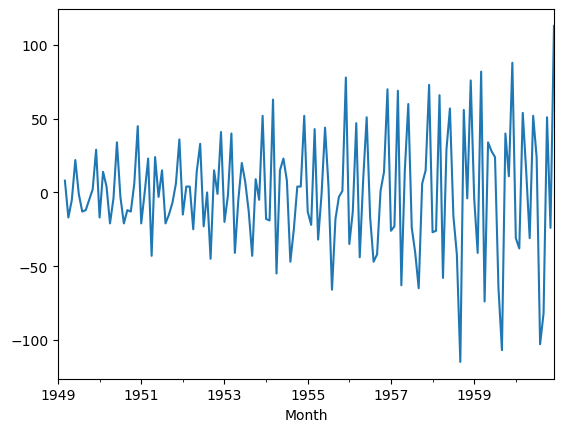

In [20]:
df_airline['Passengers Second Difference'].plot()


Mean appears to be constant and data appears to be Stationary. If this is true Standard Deviation (SD) is also constant.


In [21]:
# Performing the Dickey Fuller test to see if the 2nd differencing has made the data set stationary
#droping the nan rows

adf_test(df_airline['Passengers Second Difference'].dropna())

(-16.384231542468488, 2.7328918500143186e-29, 11, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 988.6020417275604)


ADF Statistics:  -16.384231542468488
p- value: 2.7328918500143186e-29
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [22]:
# Since this data set is a Seasonal data set
# Need to check if the data set is Stationary for 12 months (shift 12)

df_airline['Passengers 12 Difference'] = df_airline['Thousands of Passengers'] - df_airline['Thousands of Passengers'].shift(12)

In [23]:
adf_test(df_airline['Passengers 12 Difference'].dropna())

(-3.3830207264924805, 0.011551493085514982, 1, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 919.527129208137)


ADF Statistics:  -3.3830207264924805
p- value: 0.011551493085514982
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary



This means we only need 1 pass of difference to make the Season difference Stationary. For Seasonal ARIMA tends to not perform well, SARIMAX is typically used.


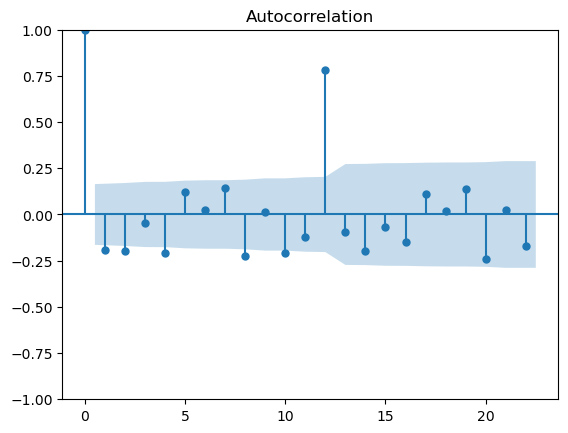

In [24]:
#ACF -> Auto Correlation Function

acf = plot_acf(df_airline['Passengers Second Difference'].dropna())


From the first large peak at x = 0 to the 2nd large peak at x = 12, this is a q value of 13. This means there is seasonality in the data set.


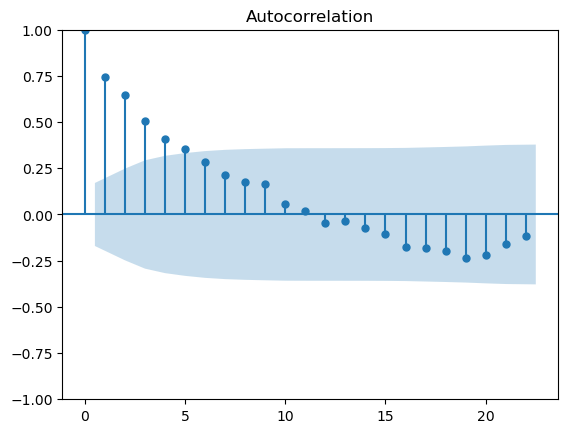

In [25]:
#Looking at the Seasonal Stationary Data

acf12 = plot_acf(df_airline['Passengers 12 Difference'].dropna())


The q value for this plot is 5. The x=0 line is not counted, it is outside of the shaded region. Leaving x=1 to x=5 above the upper bound making the q value 5.



The shaded portion of the plots repsesents the upper and lower bounds. All points that are outside of either bounds are considered to be critical dates (x-axis). The increase of the upper and lower bounds means the error is increasing.

For ACF plots Pearson Correlation is used to determin the correlation value (y-axis). ACF is looking for a direct or indirect impact. ACF is performing Moving Average (MA) giving q value.

PACF is performing Auto Regression (AR) giving p value. The d value is the differencing value (2) or (1 for seasonal).


/Users/lynnpowell/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


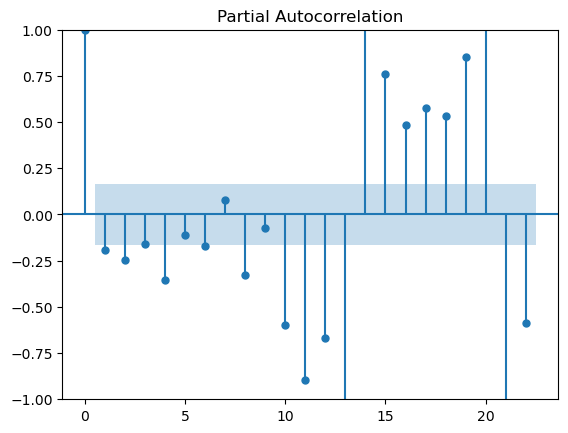

In [26]:
# PACF -> Partial Auto Crrelation Function

pacf = plot_pacf(df_airline['Passengers Second Difference'].dropna())

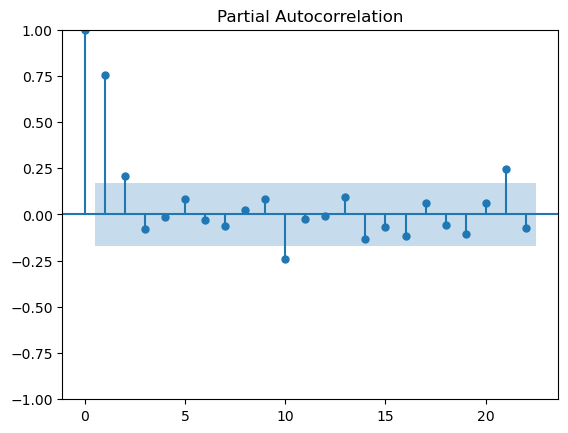

In [27]:
pacf12 = plot_pacf(df_airline['Passengers 12 Difference'].dropna())

 p = 2 (x[1], x[2]) and p = 10 (x[1] to x[10]). 

In [28]:
#df_airline.head(15)
df_airline.tail()

,Thousands of Passengers,Passengers First Difference,Passengers Second Difference,Passengers 12 Difference
Month,,,,
1960-08-01,606.0,-16.0,-103.0,47.0
1960-09-01,508.0,-98.0,-82.0,45.0
1960-10-01,461.0,-47.0,51.0,54.0
1960-11-01,390.0,-71.0,-24.0,28.0
1960-12-01,432.0,42.0,113.0,27.0


In [29]:
#Creating time limits

train_dataset_end = datetime(1955,12,1)
test_dataset_end = datetime(1960,12,1)

In [30]:
#Creating a train test split

train_data = df_airline[:train_dataset_end]
test_data = df_airline[train_dataset_end + timedelta(days=1) : test_dataset_end]

In [31]:
print('Train Data')
print(train_data.head())
print('\n')
print('Test Data')
print(test_data.head())

Train Data
            Thousands of Passengers  Passengers First Difference  \
Month                                                              
1949-01-01                    112.0                          NaN   
1949-02-01                    118.0                          6.0   
1949-03-01                    132.0                         14.0   
1949-04-01                    129.0                         -3.0   
1949-05-01                    121.0                         -8.0   

            Passengers Second Difference  Passengers 12 Difference  
Month                                                               
1949-01-01                           NaN                       NaN  
1949-02-01                           NaN                       NaN  
1949-03-01                           8.0                       NaN  
1949-04-01                         -17.0                       NaN  
1949-05-01                          -5.0                       NaN  


Test Data
            Thous


### ARIMA Model


In [32]:
# Looking at the Passenger Second Difference data
# PACF plot (counting x[1] to x[10] the first large spike) -> p = 10
# 2 passes of differencing -> d = 2
# ACF plot (x[1] to x[12] first large spike) -> q = 12

# order = (p, d, q)

model_arima = ARIMA(train_data['Thousands of Passengers'], order = (10,2,12))

/Users/lynnpowell/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/lynnpowell/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/lynnpowell/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [33]:
model_arima_fit = model_arima.fit()

/Users/lynnpowell/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/lynnpowell/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [34]:
model_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                  
===================================================================================
Dep. Variable:     Thousands of Passengers   No. Observations:                   84
Model:                    ARIMA(10, 2, 12)   Log Likelihood                -307.733
Date:                     Mon, 09 Jan 2023   AIC                            661.465
Time:                             13:04:14   BIC                            716.820
Sample:                         01-01-1949   HQIC                           683.689
                              - 12-01-1955                                         
Covariance Type:                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0468      0.115      0.408      0.683      -0.178       0.271
ar.L2         -1.0428      0.084    -12.488      0.000      -1.207      -0.879
ar.L3          0.0885      0.139      0.638      0.523      -0.183       0.360
ar.L4         -1.0257      0.131     -7.832      0.000      -1.282      -0.769
ar.L5          0.0657      0.155      0.423      0.672      -0.239       0.370
ar.L6         -0.9859      0.143     -6.879      0.000      -1.267      -0.705
ar.L7          0.0174      0.142      0.123      0.902      -0.261       0.296
ar.L8         -0.9822      0.122     -8.020      0.000      -1.222      -0.742
ar.L9         -0.0069      0.095     -0.073      0.942      -0.193       0.179
ar.L10        -0.9389      0.085    -11.084      0.000      -1.105      -0.773
ma.L1         -1.2856      0.254     -5.059      0.000      -1.784      -0.788
ma.L2          1.2391      0.358      3.457      0.001       0.537       1.942
ma.L3         -1.4409      0.436     -3.304      0.001      -2.296      -0.586
ma.L4          1.3751      0.506      2.716      0.007       0.383       2.368
ma.L5         -1.2155      0.574     -2.117      0.034      -2.341      -0.090
ma.L6          1.0824      0.660      1.640      0.101      -0.211       2.376
ma.L7         -1.0695      0.715     -1.497      0.134      -2.470       0.331
ma.L8          0.8855      0.819      1.081      0.280      -0.719       2.490
ma.L9         -0.7848      0.737     -1.065      0.287      -2.228       0.659
ma.L10         0.5231      0.601      0.870      0.384      -0.655       1.702
ma.L11        -0.4131      0.455     -0.908      0.364      -1.304       0.478
ma.L12         0.1335      0.273      0.489      0.625      -0.402       0.669
sigma2        77.2233     16.201      4.767      0.000      45.470     108.977
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 4.73
Prob(Q):                              0.99   Prob(JB):                         0.09
Heteroskedasticity (H):               2.12   Skew:                             0.59
Prob(H) (two-sided):                  0.06   Kurtosis:                         2.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""


Analyzing Summary Table:

L represents the lags for MA (moving average) and AR (auto regression). If this value in the "P>|z|" is less than 0.05, this means that lag value is considered critical (example ar.L2, ar.L4, ...)


In [35]:
## prediction for just a section of data

pred_start_date = test_data.index[0]
print('Pred Start Date: ', pred_start_date)
pred_end_date = test_data.index[-1]
print('Pred End Date: ', pred_end_date)

Pred Start Date:  1956-01-01 00:00:00
Pred End Date:  1960-12-01 00:00:00


In [36]:
pred = model_arima_fit.predict(start=pred_start_date, end=pred_end_date)

#To find the residuals
residuals = test_data['Thousands of Passengers'] - pred

In [37]:
residuals

Month
1956-01-01      0.749545
1956-02-01      7.488725
1956-03-01     21.821576
1956-04-01     14.416836
1956-05-01     18.896810
1956-06-01     28.642291
1956-07-01     24.512368
1956-08-01     33.112146
1956-09-01     14.924573
1956-10-01      3.094761
1956-11-01     -0.811752
1956-12-01      3.367598
1957-01-01      3.914157
1957-02-01      7.202425
1957-03-01     39.054239
1957-04-01     23.492833
1957-05-01     28.895788
1957-06-01     49.297676
1957-07-01     50.439120
1957-08-01     70.449489
1957-09-01     38.719276
1957-10-01     14.764472
1957-11-01      2.478161
1957-12-01      6.536208
1958-01-01      1.449233
1958-02-01     -0.384800
1958-03-01     23.074497
1958-04-01     -2.505294
1958-05-01      9.767885
1958-06-01     35.427843
1958-07-01     50.503663
1958-08-01     83.706126
1958-09-01     13.345275
1958-10-01     -2.594759
1958-11-01    -23.187966
1958-12-01    -19.299546
1959-01-01     -5.699582
1959-02-01     -1.244065
1959-03-01     44.850428
1959-04-01     19.4

<AxesSubplot:ylabel='Density'>

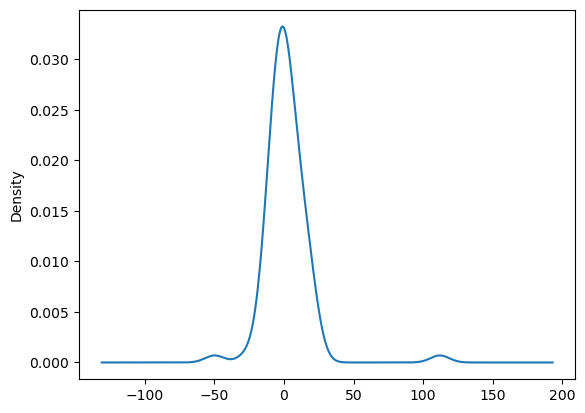

In [38]:
model_arima_fit.resid.plot(kind='kde')

In [39]:
test_data['predicted_arima'] = pred

/var/folders/t3/m14fghtd0fs5gl_s5tzd3h500000gn/T/ipykernel_3673/2865365637.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_arima'] = pred


<AxesSubplot:xlabel='Month'>

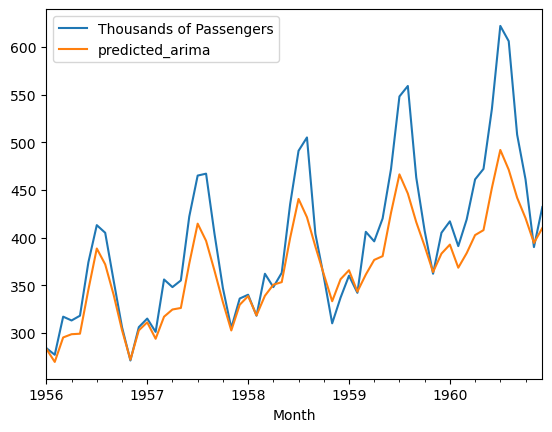

In [40]:
test_data[['Thousands of Passengers', 'predicted_arima']].plot()


### SARIMAX Model


In [41]:
# Looking at the Passenger 12 Difference data
#  order
# PACF plot (pacf12) (counting out of bounds) -> p = 4
# 0 passes of differencing -> d = 0
# ACF plot (acf12) (counting out of bounds) -> q = 5

#  seasonal order
# p = 0 or 1 (value from PACF used in order)
# 1 pass of differencing -> d = 1
# q = 0 or 1 (value from ACF used in order)
# s = 12 (12 months in a year)

# order = (P, D, Q)
#seasonal_order = (P,D,Q,s)

model_sarimax = SARIMAX(train_data['Thousands of Passengers'], order=(4,1,5), seasonal_order=(0,1,0,12))

/Users/lynnpowell/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/lynnpowell/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [42]:
model_sarimax_fit = model_sarimax.fit()

/Users/lynnpowell/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/lynnpowell/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.18072D+00    |proj g|=  2.59144D-01

At iterate    5    f=  3.11473D+00    |proj g|=  1.50451D-02

At iterate   10    f=  3.11158D+00    |proj g|=  2.41463D-02

At iterate   15    f=  3.10423D+00    |proj g|=  1.02400D-01

At iterate   20    f=  3.09877D+00    |proj g|=  4.25660D-02

At iterate   25    f=  3.08917D+00    |proj g|=  2.34754D-02

At iterate   30    f=  3.08610D+00    |proj g|=  4.71273D-02

At iterate   35    f=  3.08498D+00    |proj g|=  7.66451D-02

At iterate   40    f=  3.08467D+00    |proj g|=  6.88320D-03

At iterate   45    f=  3.08463D+00    |proj g|=  7.30943D-03

At iterate   50    f=  3.08456D+00    |proj g|=  1.76373D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/lynnpowell/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [43]:
model_sarimax_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:             Thousands of Passengers   No. Observations:                   84
Model:             SARIMAX(4, 1, 5)x(0, 1, [], 12)   Log Likelihood                -259.103
Date:                             Mon, 09 Jan 2023   AIC                            538.207
Time:                                     13:04:15   BIC                            560.834
Sample:                                 01-01-1949   HQIC                           547.205
                                      - 12-01-1955                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6610      0.423      1.564      0.118      -0.167       1.489
ar.L2         -0.6223      0.637     -0.977      0.328      -1.870       0.626
ar.L3          0.0852      0.574      0.149      0.882      -1.039       1.209
ar.L4          0.4710      0.504      0.934      0.350      -0.517       1.459
ma.L1         -0.9714      0.561     -1.731      0.084      -2.072       0.129
ma.L2          0.9708      2.568      0.378      0.705      -4.063       6.004
ma.L3         -0.6552      1.482     -0.442      0.658      -3.560       2.249
ma.L4         -0.2040      1.130     -0.181      0.857      -2.418       2.010
ma.L5         -0.1064      0.361     -0.295      0.768      -0.813       0.600
sigma2        80.8892    201.630      0.401      0.688    -314.298     476.076
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 1.07
Prob(Q):                              0.81   Prob(JB):                         0.59
Heteroskedasticity (H):               2.27   Skew:                             0.26
Prob(H) (two-sided):                  0.05   Kurtosis:                         2.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
## prediction for just a section of data

pred_start_date = test_data.index[0]
print('Pred Start Date: ', pred_start_date)
pred_end_date = test_data.index[-1]
print('Pred End Date: ', pred_end_date)

Pred Start Date:  1956-01-01 00:00:00
Pred End Date:  1960-12-01 00:00:00


In [45]:
pred_sarimax = model_sarimax_fit.predict(start=pred_start_date, end=pred_end_date)

#To find the residuals
residuals_sarimax = test_data['Thousands of Passengers'] - pred

In [46]:
#residuals_sarimax
#model_sarimax_fit.resid.plot()

<AxesSubplot:ylabel='Density'>

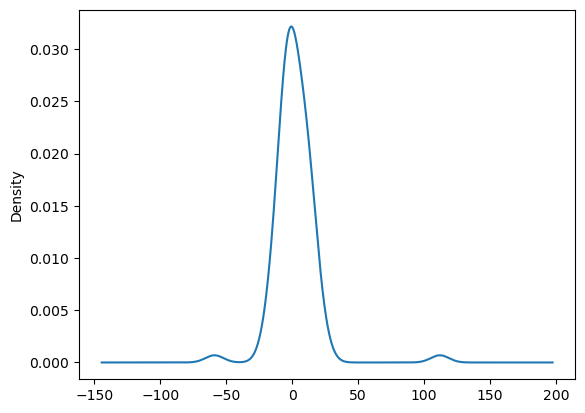

In [47]:
model_sarimax_fit.resid.plot(kind='kde')

In [48]:
test_data['predicted_sarimax'] = pred_sarimax

/var/folders/t3/m14fghtd0fs5gl_s5tzd3h500000gn/T/ipykernel_3673/3969458044.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_sarimax'] = pred_sarimax


In [49]:
test_data.head()

,Thousands of Passengers,Passengers First Difference,Passengers Second Difference,Passengers 12 Difference,predicted_arima,predicted_sarimax
Month,,,,,,
1956-01-01,284.0,6.0,-35.0,42.0,283.250455,281.757563
1956-02-01,277.0,-7.0,-13.0,44.0,269.511275,270.960905
1956-03-01,317.0,40.0,47.0,50.0,295.178424,300.786770
1956-04-01,313.0,-4.0,-44.0,44.0,298.583164,306.521094
1956-05-01,318.0,5.0,9.0,48.0,299.103190,306.897159


<AxesSubplot:xlabel='Month'>

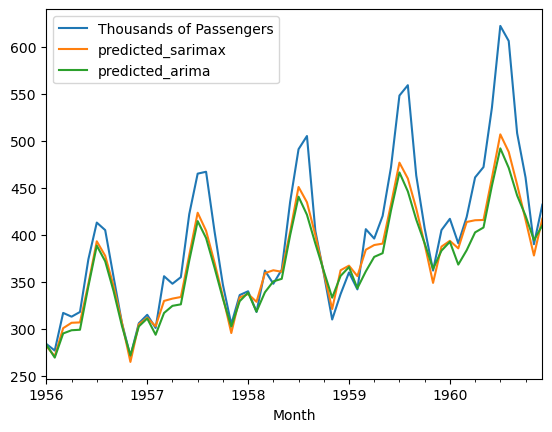

In [50]:
test_data[['Thousands of Passengers', 'predicted_sarimax', 'predicted_arima']].plot()